<a href="https://colab.research.google.com/github/Manjiri-Satam/NLP_ResearchNote/blob/main/NLP_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Decoding a Decade: A Temporal Analysis of India's Most Prominent News Topics

Natural Language Processing, Fall 2024 <br>
Manjiri Girish Satam (235789)


### IMPORT LIBRARIES

In [ ]:
import pandas as pd
import re

In [ ]:
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams

nltk.download('punkt')  # For tokenization
nltk.download('stopwords')  # For stopwords
nltk.download('punkt_tab')
nltk.download('wordnet')  # For lemmatization
nltk.download('omw-1.4')  # For extended WordNet data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### DATA

In [ ]:
data = pd.read_csv("india-news-headlines.csv", on_bad_lines='skip')

In [ ]:
# Split the publish_date column into year, month, and day
data['publish_date'] = pd.to_datetime(data['publish_date'], format='%Y%m%d')
data['year'] = data['publish_date'].dt.year
data['month'] = data['publish_date'].dt.month
data['day'] = data['publish_date'].dt.day

In [ ]:
# Group by 'year' and count the number of headlines
data.groupby('year').size().reset_index(name='headline_count')

In [ ]:
data_10 = data[data['publish_date'].dt.year > 2013]

### DATA CLEANING/PRE PROCESSING

*   Convert Text to Lowercase
*   Remove Punctuation and Special Characters
*   Remove Stopwords & Tokenization
*   Lemmatization



In [ ]:
# lower case
data_10['clean_headlines'] = data_10['headline_text'].str.lower()

<ipython-input-22-8f93a1c499df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_10['clean_headlines'] = data_10['headline_text'].str.lower()


In [ ]:
# remove punctuation & special character
data_10['clean_headlines'] = data_10['clean_headlines'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

<ipython-input-23-28067d4a5357>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_10['clean_headlines'] = data_10['clean_headlines'].apply(lambda x: re.sub(r'[^\w\s]', '', x))


In [ ]:
# using nltk- stopword and tokenization

# Load stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean and tokenize text
def remove_stopwords_nltk(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return " ".join(filtered_tokens)

# Apply NLTK preprocessing to the data
data_10['clean_headlines'] = data_10['clean_headlines'].apply(remove_stopwords_nltk)

<ipython-input-24-cd3388b2c78b>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_10['clean_headlines'] = data_10['clean_headlines'].apply(remove_stopwords_nltk)


In [ ]:
# Using NLKT- lemmatization

#Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to perform tokenization and lemmatization
def lemmatize_nltk(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    # Join the lemmatized tokens back into a single string
    return " ".join(lemmatized_tokens)


In [ ]:
# Apply the lemmatization function to the data
data_10['clean_headlines'] = data_10['clean_headlines'].apply(lemmatize_nltk)

<ipython-input-26-53f432c86c8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_10['clean_headlines'] = data_10['clean_headlines'].apply(lemmatize_nltk)


### LDA TOPIC MODELLING



*   Convert Text to Bag-of-Words
*   Apply LDA Model
* Extract Topics
* Assign Topics to Headlines




In [ ]:
# Group the dataset by year
results_10 = []

# Loop through each year
for year, group in data_10.groupby('year'):
    print(f"Processing year: {year}")

    # Extract the 'clean_headlines' for the current year
    corpus = group['clean_headlines'].dropna()

    # Step 1: Create Bag-of-Words matrix
    vectorizer = CountVectorizer(max_df=0.9, min_df=5, stop_words='english')
    bow_matrix = vectorizer.fit_transform(corpus)

    # Step 2: Create and fit the LDA model
    num_topics = 10  # Set the number of topics
    lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=123)
    lda_model.fit(bow_matrix)

    # Step 3: Get feature names (words)
    words = vectorizer.get_feature_names_out()

    # Step 4: Extract topics and assign headlines
    topic_assignments = lda_model.transform(bow_matrix).argmax(axis=1)
    group = group.reset_index(drop=True)  # Reset index for proper assignment
    group['topic'] = topic_assignments  # Assign topics to the headlines

    # Step 5: Summarize topics
    for topic_idx in range(num_topics):
        topic_words = [words[i] for i in lda_model.components_[topic_idx].argsort()[:-11:-1]]  # Top 10 words
        count = sum(group['topic'] == topic_idx)  # Count of headlines under the topic

        # Append results as a dictionary
        results_10.append({
            'year': year,
            'topic': topic_idx + 1,  # 1-based indexing for topics
            'top_words': ', '.join(topic_words),
            'headline_count': count
        })

# Convert results to a DataFrame
results_10_df = pd.DataFrame(results_10)

# Sort the results by year and headline count in descending order
results_10_df = results_10_df.sort_values(by=['year', 'headline_count'], ascending=[True, False])

Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019
Processing year: 2020
Processing year: 2021
Processing year: 2022
Processing year: 2023


In [ ]:
# Save the DataFrame to a CSV file
results_10_df.to_csv("yearly_topic_summaries_10.csv", index=False)

### VISUALIATION

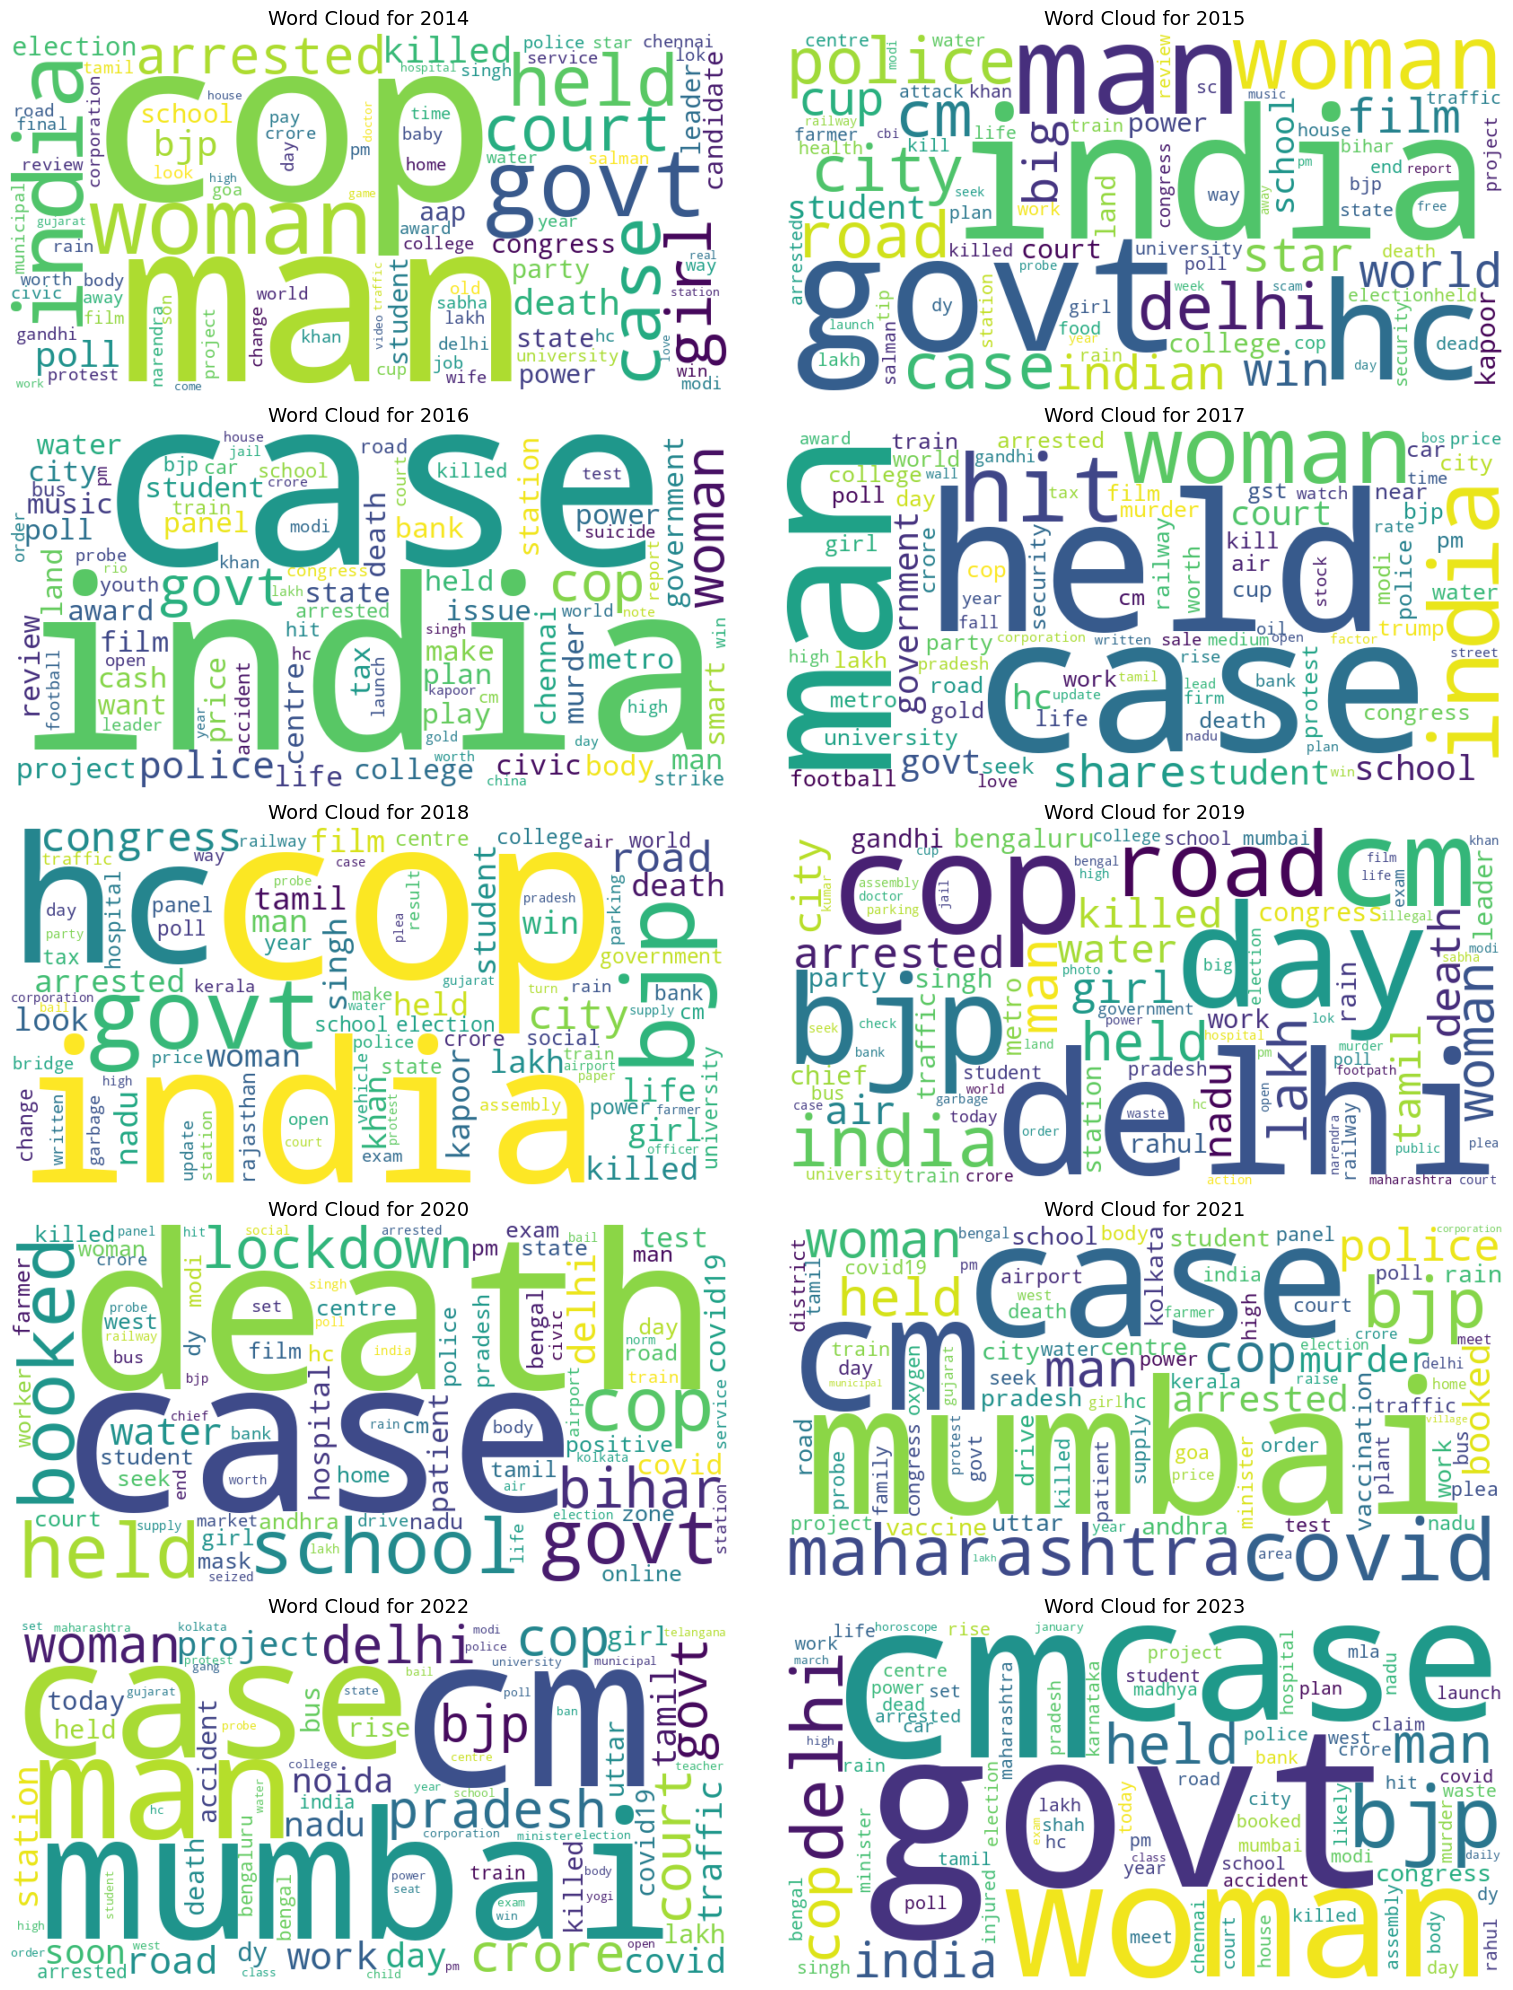

In [7]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the dataset
file_path = "yearly_topic_summaries_10.csv"  # Replace with your file path
data = pd.read_csv(file_path)

# Define words to exclude
excluded_words = {"say", "says", "new"}

# Prepare for saving and arranging word clouds
fig, axes = plt.subplots(5, 2, figsize=(16, 20))  # 5 rows, 2 columns
axes = axes.flatten()  # Flatten axes for easier iteration

# Loop through each year to generate word clouds
for idx, year in enumerate(sorted(data['year'].unique())):
    # Filter data for the specific year
    year_data = data[data['year'] == year]

    # Combine all top words for the year into a single string
    combined_words = " ".join(year_data['top_words'])

    # Preprocess and filter excluded words
    combined_words = combined_words.replace(",", " ")  # Remove any commas if present
    combined_words = " ".join([
        word.strip() for word in combined_words.split()
        if word.lower() not in excluded_words
    ])

    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_words)

    # Plot the word cloud in the respective subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Word Cloud for {year}", fontsize=14)

    # Save each word cloud as an individual image
    wordcloud.to_file(f"word_cloud_{year}_filtered.png")  # Saves the image to the current directory

# Remove empty plots if there are less than 10 years
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and save the full grid as an image
plt.tight_layout()
plt.savefig("word_clouds_grid_filtered.png")  # Save the grid of word clouds
plt.show()
